In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy as calculate_entropy
from tqdm import tqdm

# Directories for SCC, Melanoma, and BCC images for both training and validation sets
train_scc_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/scc"
train_mel_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/mel"
train_bcc_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Training/train/bcc"
val_scc_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/scc"
val_mel_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/mel"
val_bcc_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Validation/bcc"

# Simplified Feature Extraction Function
def extract_features(image):
    features = {}

    # Resize image
    image = cv2.resize(image, (128, 128))

    # Color Features - Mean and Standard Deviation in RGB channels
    if len(image.shape) == 3:  # color image
        features['r_mean'] = np.mean(image[:, :, 0])
        features['g_mean'] = np.mean(image[:, :, 1])
        features['b_mean'] = np.mean(image[:, :, 2])
        features['r_std'] = np.std(image[:, :, 0])
        features['g_std'] = np.std(image[:, :, 1])
        features['b_std'] = np.std(image[:, :, 2])
    else:  # grayscale image
        features['grayscale_mean'] = np.mean(image)
        features['grayscale_std'] = np.std(image)

    # Grayscale conversion for texture features
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Simple Texture Features - Mean and Standard Deviation
    features['texture_mean'] = np.mean(grayscale_image)
    features['texture_std'] = np.std(grayscale_image)

    # Entropy
    hist = cv2.calcHist([grayscale_image], [0], None, [256], [0, 256]).flatten()
    features['entropy'] = calculate_entropy(hist)

    return features

# Function to load and label images from a directory
def load_images_with_labels(directories, label):
    images = []
    for directory in directories:
        images.extend([(os.path.join(directory, f), label) for f in os.listdir(directory) if f.endswith('.jpg')])
    return images

# Combine and shuffle all images from training set
train_images = (
    load_images_with_labels([train_scc_dir], 'SCC') +
    load_images_with_labels([train_mel_dir], 'Melanoma') +
    load_images_with_labels([train_bcc_dir], 'BCC')
)
random.shuffle(train_images)

# Combine all images from validation set (kept separate for evaluation)
val_images = (
    load_images_with_labels([val_scc_dir], 'SCC') +
    load_images_with_labels([val_mel_dir], 'Melanoma') +
    load_images_with_labels([val_bcc_dir], 'BCC')
)

# Feature extraction with progress tracking for both training and validation sets
def generate_features_dataframe(image_paths_labels):
    features_list = []
    with tqdm(total=len(image_paths_labels), desc="Extracting Features", unit="image") as pbar:
        for image_path, label in image_paths_labels:
            image = cv2.imread(image_path)
            if image is not None:
                features = extract_features(image)
                features['label'] = label
                features_list.append(features)
            pbar.update(1)  # Update progress bar by 1 step after processing each image
    return pd.DataFrame(features_list)

# Generate features for training and validation sets
train_df = generate_features_dataframe(train_images)
val_df = generate_features_dataframe(val_images)

# Encode labels for classification
label_map = {'SCC': 0, 'Melanoma': 1, 'BCC': 2}
train_df['label'] = train_df['label'].map(label_map)
val_df['label'] = val_df['label'].map(label_map)

# Split features and labels
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train XGBoost model with basic parameters
xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train)

# Predict on validation set
y_pred = xgb.predict(X_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
kappa = cohen_kappa_score(y_val, y_pred)

print("\nXGBoost Results")
print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa: {kappa:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["SCC", "Melanoma", "BCC"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))



Extracting Features: 100%|██████████| 1270/1270 [37:03<00:00,  1.75s/image]



XGBoost Results
Accuracy: 0.7386
Kappa: 0.5085

Classification Report:
              precision    recall  f1-score   support

         SCC       0.82      0.15      0.25        94
    Melanoma       0.77      0.82      0.79       678
         BCC       0.69      0.74      0.72       498

    accuracy                           0.74      1270
   macro avg       0.76      0.57      0.59      1270
weighted avg       0.74      0.74      0.72      1270


Confusion Matrix:
[[ 14  38  42]
 [  2 554 122]
 [  1 127 370]]


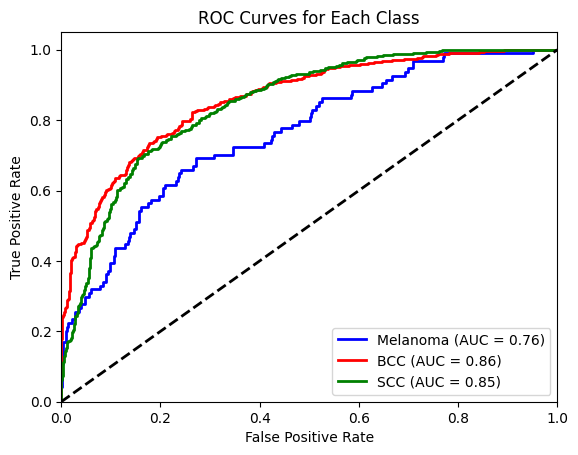

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC calculation
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

# Get the number of classes
n_classes = y_val_bin.shape[1]

# Initialize variables to store results
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
class_names = ["Melanoma", "BCC", "SCC"]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], xgb.predict_proba(X_val_scaled)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot each class's ROC curve
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()


# TESTING

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Directory for test images
test_dir = "/content/drive/Shareddrives/CAD/CADx First Project/Second Challenge/Data/Test/testX"

# Function to load test images in the correct order based on file numbering
def load_ordered_test_images(directory):
    image_paths = [os.path.join(directory, f) for f in sorted(os.listdir(directory)) if f.endswith('.jpg')]
    return image_paths

# Load test image paths
test_images = load_ordered_test_images(test_dir)

# Feature extraction function used on the test set (ensure it matches the training process)
def extract_features(image):
    features = {}
    # Resize to standardize
    image = cv2.resize(image, (128, 128))

    # Extract mean and std for each RGB channel
    if len(image.shape) == 3:
        features['r_mean'] = np.mean(image[:, :, 0])
        features['g_mean'] = np.mean(image[:, :, 1])
        features['b_mean'] = np.mean(image[:, :, 2])
        features['r_std'] = np.std(image[:, :, 0])
        features['g_std'] = np.std(image[:, :, 1])
        features['b_std'] = np.std(image[:, :, 2])
    else:
        features['grayscale_mean'] = np.mean(image)
        features['grayscale_std'] = np.std(image)

    # Texture mean and std (single statistic as simplified)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features['texture_mean'] = np.mean(grayscale_image)
    features['texture_std'] = np.std(grayscale_image)

    # Entropy calculation
    hist = cv2.calcHist([grayscale_image], [0], None, [256], [0, 256]).flatten()
    features['entropy'] = -np.sum(hist * np.log2(hist + 1e-10))  # Add small epsilon to avoid log(0)

    return features

# Generate features for test set
def generate_test_features(image_paths):
    features_list = []
    for image_path in tqdm(image_paths, desc="Extracting Test Features"):
        image = cv2.imread(image_path)
        if image is not None:
            features = extract_features(image)
            features_list.append(features)
    return pd.DataFrame(features_list)

# Extract test features
X_test = generate_test_features(test_images)

# Standardize the test set based on the training scaler
X_test_scaled = scaler.transform(X_test)

# Predict on the test set
y_test_pred = xgb.predict(X_test_scaled)

# Prepare results for CSV output
image_names = [os.path.basename(path) for path in test_images]
output_df = pd.DataFrame({"Image Name": image_names, "Classification Result": y_test_pred})
output_df['Classification Result'] = output_df['Classification Result'].map({0: 0, 1: 1, 2: 2})  # 0=Mel, 1=BCC, 2=SCC

# Save predictions to CSV
output_df.to_csv("classification_results.csv", index=False, header=False)
print("Predictions saved to 'classification_results.csv'")


Extracting Test Features: 100%|██████████| 2126/2126 [01:26<00:00, 24.65it/s]

Predictions saved to 'classification_results.csv'
